# VR-Methods: SGD(+SWA)-vs-Nesterov-vs-SVRG
## Author: Shtykov Pavel 

In [1]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from typing import Callable, Any
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.preprocessing import StandardScaler
from time import time

## Test on Synthetic Data

In [2]:
def logreg(w, X, y, mu):
    return (
        np.log(1 + np.exp(-X.dot(w) * y)).mean() 
        + mu * np.linalg.norm(w) ** 2 / 2
    )


def grad_logreg(w, X, y, mu):
    y_X = y.reshape(-1, 1) * X
    return (
        (-y_X / (1 + np.exp(y_X @ w)).reshape(-1, 1)).mean(axis=0) 
        + mu * w
    )

In [3]:
d = 30
N = 10000
wtrue = np.random.randn(d)
X_simple = np.random.randn(N, d)
y_simple = (1.0 / (1.0 + np.exp(-X_simple @ wtrue)) >= np.random.rand(N)) * 2.0 - 1.0
w0 = np.random.randn(d)

X_simple.shape, y_simple.shape

((10000, 30), (10000,))

In [4]:
class SWA:
    def __init__(self, size_buffer, start_from_N_call):
        self.size_buffer = size_buffer
        self.start_from_N_call = start_from_N_call 
        self.i = 0
        self.buffer = []

    def __call__(self, x):
        if self.i < self.start_from_N_call:
            res = x
            self.i += 1
            return res

        self.buffer.append(x)
        if len(self.buffer) > self.size_buffer:
            self.buffer.pop(0)
        res = np.mean(self.buffer, axis=0)
        self.i += 1
        return res

def grad(w, xi, yi, mu):
    return -xi * yi / (1.0 + np.exp(yi * np.dot(xi, w))) + mu * w 

def sgd(w0, alpha, X, y, niters, wopt=None, use_swa=False, swa_buffer_size=20, swa_ratio=0.7, mu=0):
    w = w0
    (N, d) = X.shape

    if wopt is not None:
        sgd_dist_to_optimum = np.zeros(niters)
    conv_rate = []

    updater = SWA(swa_buffer_size, int(swa_ratio * niters)) if use_swa else lambda x: x
    times = []
    start = time()

    for k in range(niters):
        i = np.random.randint(N)
        xi = X[i,:]
        yi = y[i]
        w_new = updater(w - alpha * grad(w, xi, yi, mu))
        
        times.append(time() - start)
        conv_rate.append(np.linalg.norm(w_new - w))
        w = w_new 
        if wopt is not None:
            sgd_dist_to_optimum[k] = np.linalg.norm(w - wopt)

    if wopt is not None:
        return w, conv_rate, times, sgd_dist_to_optimum
    return w, conv_rate, times

def svrg(w0, alpha, X, y, niters, nepochs, wopt=None, mu=0):
    w = w0
    (N, d) = X.shape
    
    if wopt is not None:
        dist_to_optimum = np.zeros(nepochs*niters)
    conv_rate = []
    times = []
    start = time()

    for epi in range(nepochs):
        what = w
        ghat = np.zeros(d)
        for i in range(N):
            xi = X[i,:]
            yi = y[i]
            ghat += grad(what, xi, yi, mu)
        ghat /= N
        for k in range(niters):
            i = np.random.randint(N)
            xi = X[i,:]
            yi = y[i]
            w_new = w - alpha * (grad(w, xi, yi, mu) - grad(what, xi, yi, mu) + ghat)

            conv_rate.append(np.linalg.norm(w - w_new))
            w = w_new
            times.append(time() - start)
            if wopt is not None:    
                dist_to_optimum[epi*niters + k] = np.linalg.norm(w - wopt)

    if wopt is not None:       
        return w, conv_rate, times, dist_to_optimum
    return w, conv_rate, times

def nesterov(
        grad_f: Callable, x_0, step_size: Callable, betta: Callable, 
        N = 10**3, eps = 10**-5, x_opt = None, use_swa=False, swa_buffer_size=20, swa_ratio=0.7
    ):
    x_k1, x_k, y_k, y_k1 = (x_0,) * 4

    if x_opt is not None:
        dist_to_optimum = [] 
    conv_rate = []
    times = []
    start = time()

    updater = SWA(swa_buffer_size, int(swa_ratio * N)) if use_swa else lambda x: x

    for step in range(N):
        new_grad = grad_f(y_k1)

        x_k = x_k1
        y_k = y_k1

        x_k1 = updater(y_k - step_size(step) * new_grad)
        y_k1 = x_k1 + betta(step) * (x_k1 - x_k)

        conv_rate.append(np.linalg.norm(x_k1 - x_k))
        times.append(time() - start)
        if x_opt is not None:
            dist_to_optimum.append(np.linalg.norm(x_k1 - x_opt))

    if x_opt is not None:
        return x_k1, conv_rate, times, dist_to_optimum
    return x_k1, conv_rate, times

In [5]:
epochs = 1000
iters_by_epoch = 20
lr = 1e-2

L = np.mean(np.sum(X_simple ** 2, axis=1)) / 4
mu = L / 1000
mu

0.007545126082165941

In [6]:
sol_svrg, conv_rate_svrg, times_svrg, conv_opt_svrg = svrg(w0, lr, X_simple, y_simple, epochs, iters_by_epoch, wtrue, mu=mu)

sol_svrg.shape

(30,)

In [10]:
sol_sgd, conv_rate_sgd, times_sgd, conv_opt_sgd = sgd(w0, lr, X_simple, y_simple, epochs*iters_by_epoch, wtrue, mu=mu)
sol_sgd_swa, conv_rate_sgd_swa, times_sgd_swa, conv_opt_sgd_swa = sgd(w0, lr, X_simple, y_simple, epochs*iters_by_epoch, wtrue, use_swa=True, mu=mu)

sol_sgd.shape, sol_sgd_swa.shape

((30,), (30,))

In [8]:
from functools import partial


step_size = lambda _: lr

betta_mu_strongly = lambda _: (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))


grad_f = partial(grad_logreg, X=X_simple, y=y_simple, mu=mu)

sol_sgd_nester, conv_rate_nester, times_nester, conv_opt_nester = nesterov(grad_f, w0, step_size, betta_mu_strongly, x_opt=wtrue, N=epochs*iters_by_epoch)

sol_sgd_nester.shape

(30,)

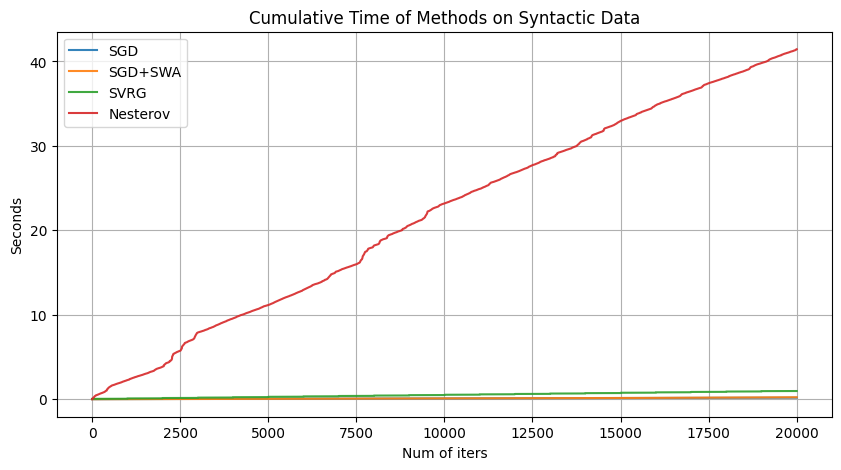

In [15]:
plt.figure(figsize=(10, 5))

plt.plot(times_sgd, label='SGD', alpha=0.9)
plt.plot(times_sgd_swa, label='SGD+SWA', alpha=0.9)
plt.plot(times_svrg, label='SVRG', alpha=0.9)
plt.plot(times_nester, label='Nesterov', alpha=0.9)
# plt.plot(times_nester_swa, label='Nesterov+SWA')

plt.title("Cummulative Time of Methods on Syntactic Data")
plt.yscale('log')
plt.ylabel('Seconds')
plt.xlabel('Num of iters')
plt.legend()
plt.grid()
plt.show()

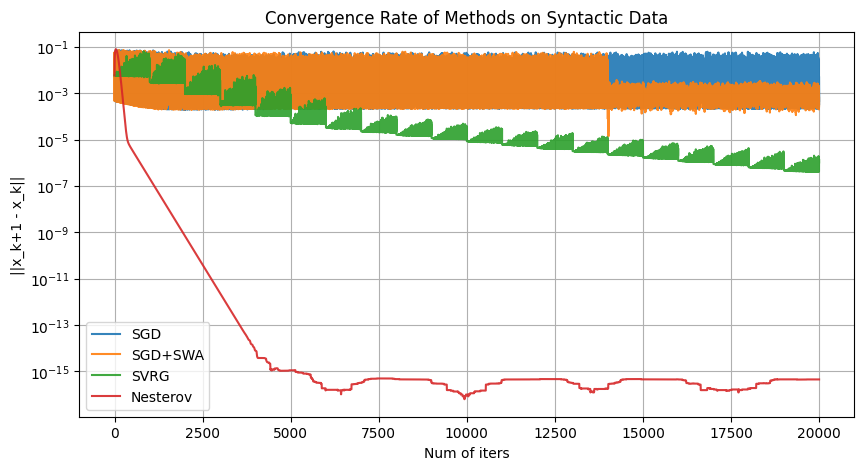

In [10]:
plt.figure(figsize=(10, 5))

plt.plot(conv_rate_sgd, label='SGD', alpha=0.9)
plt.plot(conv_rate_sgd_swa, label='SGD+SWA', alpha=0.9)
plt.plot(conv_rate_svrg, label='SVRG', alpha=0.9)
plt.plot(conv_rate_nester, label='Nesterov', alpha=0.9)
# plt.plot(conv_rate_nester_swa, label='Nesterov+SWA')

plt.title("Convergence Rate of Methods on Syntactic Data")
plt.yscale('log')
plt.ylabel('||x_k+1 - x_k||')
plt.xlabel('Num of iters')
plt.legend()
plt.grid()
plt.show()

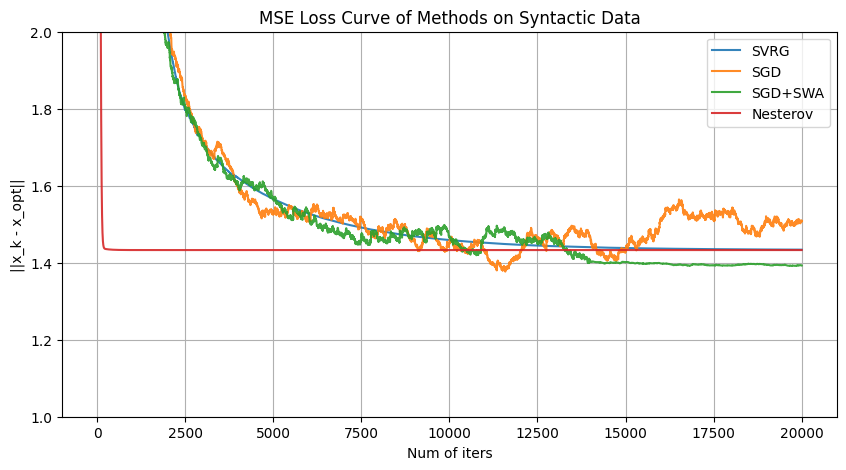

In [11]:
plt.figure(figsize=(10, 5))

plt.plot(conv_opt_svrg, label='SVRG', alpha=0.9)
plt.plot(conv_opt_sgd, label='SGD', alpha=0.9)
plt.plot(conv_opt_sgd_swa, label='SGD+SWA', alpha=0.9)
plt.plot(conv_opt_nester, label='Nesterov', alpha=0.9)
# plt.plot(conv_opt_nester_swa, label='Nesterov+SWA')

plt.title("MSE Loss Curve of Methods on Syntactic Data")
# plt.yscale('log')
plt.ylabel('||x_k - x_opt||')
plt.xlabel('Num of iters')
plt.legend()
plt.grid()
plt.ylim(1, 2)
plt.show()

## Test on Real Data for Binary Classification: Student Depression Dataset

In [12]:
dataset = "./Student Depression Dataset.csv" # https://www.kaggle.com/datasets/hopesb/student-depression-dataset?resource=download

df = pd.read_csv(dataset)
df = df.dropna()

df = df.drop(columns='id')

categorical_columns = df.select_dtypes(include=['object', 'category']).columns

df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True).astype(np.float64)

X = df_encoded.drop(columns='Depression')
y = df_encoded['Depression']
y = 2 * y - 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22318, 109), (5580, 109), (22318,), (5580,))

In [18]:
epochs = 2000
iters_by_epoch = 20
lr = 5e-3

L = np.mean(np.sum(X_train ** 2, axis=1)) / 4
mu = L / 1000
mu

w0 = np.random.randn(X_train.shape[1])

In [19]:
sol_svrg, conv_rate_svrg = svrg(w0, lr, X_train, y_train, epochs, iters_by_epoch, mu=mu)

sol_svrg.shape

(109,)

In [20]:
sol_sgd, conv_rate_sgd = sgd(w0, lr, X_train, y_train, epochs*iters_by_epoch, mu=mu)
sol_sgd_swa, conv_rate_sgd_swa = sgd(w0, lr, X_train, y_train, epochs*iters_by_epoch, use_swa=True, mu=mu)

sol_sgd.shape, sol_sgd_swa.shape

/var/folders/ty/qpt_r3m11h95l5vnmk_5r5q1btyv9b/T/ipykernel_25834/2160115234.py:22: RuntimeWarning: overflow encountered in exp
  return -xi * yi / (1.0 + np.exp(yi * np.dot(xi, w))) + mu * w


((109,), (109,))

In [21]:
from functools import partial


step_size = lambda _: lr

betta_mu_strongly = lambda _: (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))


grad_f = partial(grad_logreg, X=X_train, y=y_train, mu=mu)

sol_sgd_nester, conv_rate_nester = nesterov(grad_f, w0, step_size, betta_mu_strongly, N=epochs*iters_by_epoch)

sol_sgd_nester.shape

(109,)

In [22]:
def logistic_regression(X, w):
    return 1 / (1 + np.exp(-np.dot(X, w)))


pred_test_svrg = logistic_regression(X_test, sol_svrg)
pred_test_sgd = logistic_regression(X_test, sol_sgd)
pred_test_sgd_swa = logistic_regression(X_test, sol_sgd_swa)
pred_test_sgd_nester = logistic_regression(X_test, sol_sgd_nester)

roc_auc_svrg = roc_auc_score(y_test, pred_test_svrg)
roc_auc_sgd = roc_auc_score(y_test, pred_test_sgd)
roc_auc_sgd_swa = roc_auc_score(y_test, pred_test_sgd_swa)
roc_auc_sgd_nester = roc_auc_score(y_test, pred_test_sgd_nester)

roc_auc_svrg, roc_auc_sgd, roc_auc_sgd_swa, roc_auc_sgd_nester

(0.9174410600131564,
 0.7314236521075447,
 0.8999954669657767,
 0.9202578663956684)